In [1]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\ic2594\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [2]:
df = data.load_asset('SOLUSDT', sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = df[df.index >= '2024-01-01']
df['Market Return'] = df['Close'].pct_change()
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category,Market Return
Open time,,,,,,,,,,,,
2024-01-02,109.93,116.95,106.02,106.73,7.831366e+06,8.727018e+08,1029366,4008477.700,4.468272e+08,71.0,Greed,-0.028933
2024-01-03,106.72,109.90,85.00,98.52,1.222106e+07,1.229681e+09,1428502,6232536.620,6.274338e+08,70.0,Greed,-0.076923
2024-01-04,98.52,108.15,96.60,104.91,7.235483e+06,7.374641e+08,828177,3653791.900,3.724890e+08,68.0,Greed,0.064860
2024-01-05,104.91,105.48,95.23,99.94,6.703567e+06,6.706546e+08,792668,3291710.910,3.293771e+08,72.0,Greed,-0.047374
2024-01-06,99.93,100.30,91.53,93.77,5.151478e+06,4.896172e+08,613981,2480905.000,2.359553e+08,70.0,Greed,-0.061737
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27,137.35,140.22,135.63,138.43,2.466163e+06,3.412542e+08,1324639,1238086.879,1.714153e+08,40.0,Fear,0.007937
2025-03-28,138.44,139.05,127.69,129.49,3.892191e+06,5.155013e+08,1575782,1791046.217,2.373760e+08,44.0,Fear,-0.064581
2025-03-29,129.50,130.54,122.68,124.58,2.610066e+06,3.296431e+08,1178810,1302977.748,1.646235e+08,26.0,Fear,-0.037918


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Log = []

def objective(trial, optimal_params=None):
    if trial is not None:
        # Define the hyperparameters to tune
        window = trial.suggest_int('window', 5, 50)
        # threshold = trial.suggest_float('threshold', 0.1, 2.0)
        long = trial.suggest_float('long', 0.1, 2.0)
        short = trial.suggest_float('short', 0.1, 2.0)
        buy_long = trial.suggest_float('buy_long', 0, 1)
        buy_short = trial.suggest_float('buy_short', 0, 1)

    # If optimal_params is provided, use them instead of trial parameters
    if optimal_params is not None:
        window = optimal_params['window']
        long = optimal_params['long']
        short = optimal_params['short']
        buy_long = optimal_params['buy_long']
        buy_short = optimal_params['buy_short']


    # Calculate Moving Average and Standard Deviation
    moving_avg = df['Close'].rolling(window=window).mean()
    moving_std = df['Close'].rolling(window=window).std()

    # Calculate Z-score
    z_score = (df['Close'] - moving_avg) / moving_std

    df['Long'] = False
    df['Short'] = False

    # Strategy: Buy when Z < -threshold, Sell when Z > threshold
    df['Position'] = 0.0
    df.loc[z_score < -long, 'Position'] = buy_long  # Long
    df.loc[z_score < -long, 'Long'] = True
    df.loc[z_score > short, 'Position'] = buy_short  # Short
    df.loc[z_score > short, 'Short'] = True

    # df.loc[z_score < -threshold, 'Position'] = 1  # Long
    # df.loc[z_score > threshold, 'Position'] = 0   # Exit long

    # Shift position for returns
    df['Position'] = df['Position'].shift(1)

    # Calculate returns
    df['Strategy Return'] = df['Position'] * df['Market Return']


    df['Short Strategy Return'] = df['Short'] * df['Position'] * df['Market Return']
    df['Long Strategy Return'] = df['Long'] * df['Position'] * df['Market Return']

    # Cumulative returns
    cumulative_returns = (1 + df[['Market Return', 'Strategy Return']]).cumprod()

    # Calculate Sharpe Ratio
    sharpe_ratio = (cumulative_returns['Strategy Return'].mean() / cumulative_returns['Strategy Return'].std()) * np.sqrt(252)
    end_returns = cumulative_returns['Strategy Return'].iloc[-1] - 1

    # Log the parameters, position, and Sharpe Ratio
    # Log.append({
    #     'window': window,
    #     'long': long,
    #     'short': short,
    #     'buy_long': buy_long,
    #     'buy_short': buy_short,
    #     'sharpe_ratio': sharpe_ratio,
    #     'position': df['Position'].values,
    #     'cumulative_returns': cumulative_returns['Strategy Return'].values,
    # })

    return sharpe_ratio, end_returns

def objective_sharpe(trial, optimal_params=None):
    return objective(trial, optimal_params)[0]

def objective_end(trial, optimal_params=None):
    return objective(trial, optimal_params)[1]

In [7]:
import matplotlib.pyplot as plt
import optuna
import optuna.visualization as vis

study = optuna.create_study(direction='maximize')
for i in range(10):
    study.optimize(objective_end, n_trials=100)
    %store study


[I 2025-04-27 16:18:15,227] A new study created in memory with name: no-name-761f9976-9e7d-4ae8-95f7-f5d24760d89f
[I 2025-04-27 16:18:15,235] Trial 0 finished with value: 0.8747078418485148 and parameters: {'window': 37, 'long': 0.5119150390358218, 'short': 1.3273925169163592, 'buy_long': 0.6072443982269873, 'buy_short': 0.6098965569914225}. Best is trial 0 with value: 0.8747078418485148.
[I 2025-04-27 16:18:15,241] Trial 1 finished with value: 0.2059320474042754 and parameters: {'window': 19, 'long': 1.8594460290994577, 'short': 1.814332568923721, 'buy_long': 0.3061272124683152, 'buy_short': 0.5248392965011925}. Best is trial 0 with value: 0.8747078418485148.
[I 2025-04-27 16:18:15,247] Trial 2 finished with value: 0.3274524520792934 and parameters: {'window': 27, 'long': 0.2125199417587857, 'short': 0.7551276209455509, 'buy_long': 0.64069152868932, 'buy_short': 0.36463086361496544}. Best is trial 0 with value: 0.8747078418485148.
[I 2025-04-27 16:18:15,253] Trial 3 finished with valu

Stored 'study' (Study)


[I 2025-04-27 16:18:17,958] Trial 113 finished with value: 1.7627403789459333 and parameters: {'window': 40, 'long': 1.0162476738084716, 'short': 0.3660284303238325, 'buy_long': 0.9758182724116928, 'buy_short': 0.9234610904454342}. Best is trial 103 with value: 2.286662075938897.
[I 2025-04-27 16:18:17,974] Trial 114 finished with value: 0.802925895083946 and parameters: {'window': 42, 'long': 0.9894128766401157, 'short': 1.1531734830606162, 'buy_long': 0.9479786354074091, 'buy_short': 0.024113093977406463}. Best is trial 103 with value: 2.286662075938897.
[I 2025-04-27 16:18:17,988] Trial 115 finished with value: 1.5097475276885337 and parameters: {'window': 48, 'long': 0.8731640699006791, 'short': 0.42975497914558963, 'buy_long': 0.8512467387431528, 'buy_short': 0.8744348695632642}. Best is trial 103 with value: 2.286662075938897.
[I 2025-04-27 16:18:18,002] Trial 116 finished with value: 2.1346812226724636 and parameters: {'window': 38, 'long': 0.8075888355500901, 'short': 0.1963880

Stored 'study' (Study)


[I 2025-04-27 16:18:19,458] Trial 212 finished with value: 2.799149004981022 and parameters: {'window': 47, 'long': 0.6638557082677683, 'short': 0.3736844563215699, 'buy_long': 0.9420101086024483, 'buy_short': 0.9610294535547287}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:19,474] Trial 213 finished with value: 2.5514365521651308 and parameters: {'window': 49, 'long': 0.6777846811451731, 'short': 0.3707592124338038, 'buy_long': 0.9769934797344187, 'buy_short': 0.9555818048134003}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:19,493] Trial 214 finished with value: 1.708067367980492 and parameters: {'window': 49, 'long': 0.6359685583956182, 'short': 0.37252491997229276, 'buy_long': 0.9771214435568104, 'buy_short': 0.947003746885428}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:19,512] Trial 215 finished with value: 1.9238843302379447 and parameters: {'window': 50, 'long': 0.6722280641053342, 'short': 0.35136470

Stored 'study' (Study)


[I 2025-04-27 16:18:21,121] Trial 310 finished with value: 0.8998970923256207 and parameters: {'window': 50, 'long': 0.5783441274532166, 'short': 0.44385709853784805, 'buy_long': 0.9997727883916826, 'buy_short': 0.4407924048706176}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:21,139] Trial 311 finished with value: 1.6664557920918117 and parameters: {'window': 48, 'long': 0.6445568646371292, 'short': 0.4076772189396612, 'buy_long': 0.9467779123743433, 'buy_short': 0.9513059983121559}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:21,157] Trial 312 finished with value: 2.0343848789464687 and parameters: {'window': 49, 'long': 0.6991045259239523, 'short': 0.34697471826222137, 'buy_long': 0.96933540592506, 'buy_short': 0.9057903410844964}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:21,175] Trial 313 finished with value: 1.811557956981157 and parameters: {'window': 47, 'long': 0.7642740649110997, 'short': 0.2740564

Stored 'study' (Study)


[I 2025-04-27 16:18:22,973] Trial 410 finished with value: 1.0600437358438488 and parameters: {'window': 48, 'long': 0.8274697633181358, 'short': 0.39315968743861196, 'buy_long': 0.949571531482441, 'buy_short': 0.0713538746699326}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:22,993] Trial 411 finished with value: 1.9270756673607554 and parameters: {'window': 49, 'long': 0.7238273466220858, 'short': 0.22924747514593163, 'buy_long': 0.9795102736330183, 'buy_short': 0.9748913530647259}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:23,013] Trial 412 finished with value: 1.3962721304751318 and parameters: {'window': 45, 'long': 0.6746925884599035, 'short': 0.3196820375896399, 'buy_long': 0.99968224593623, 'buy_short': 0.9276063065820764}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:23,033] Trial 413 finished with value: 1.9239601663354233 and parameters: {'window': 47, 'long': 0.7562105190596031, 'short': 0.4728214

Stored 'study' (Study)


[I 2025-04-27 16:18:24,989] Trial 509 finished with value: 0.5376213974425939 and parameters: {'window': 49, 'long': 0.17128194290735332, 'short': 0.35459684499260363, 'buy_long': 0.9844224942479661, 'buy_short': 0.8861800201320668}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:25,011] Trial 510 finished with value: 2.191459075548223 and parameters: {'window': 48, 'long': 0.7882341148129339, 'short': 0.40782850875375337, 'buy_long': 0.9538793711397092, 'buy_short': 0.9424051812626129}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:25,033] Trial 511 finished with value: 2.242416485852849 and parameters: {'window': 50, 'long': 0.644128580624628, 'short': 0.5325774194236338, 'buy_long': 0.968851513937519, 'buy_short': 0.9999836327235152}. Best is trial 196 with value: 2.8361273972904355.
[I 2025-04-27 16:18:25,055] Trial 512 finished with value: 1.5581575052747114 and parameters: {'window': 45, 'long': 0.7152534509297894, 'short': 0.3394888

Stored 'study' (Study)


[I 2025-04-27 16:18:27,170] Trial 608 finished with value: 1.967340943990075 and parameters: {'window': 46, 'long': 0.7698572001642284, 'short': 0.2945509933533671, 'buy_long': 0.9669750986230334, 'buy_short': 0.9869249059553381}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:27,193] Trial 609 finished with value: 2.570530494403731 and parameters: {'window': 49, 'long': 0.6950560782597179, 'short': 0.3748749370163439, 'buy_long': 0.999896372812332, 'buy_short': 0.9405255613080151}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:27,217] Trial 610 finished with value: 1.6356820309743427 and parameters: {'window': 48, 'long': 0.6241347952506743, 'short': 0.33774668160284543, 'buy_long': 0.9998150072745818, 'buy_short': 0.999655802785093}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:27,241] Trial 611 finished with value: 1.843569686987372 and parameters: {'window': 47, 'long': 0.9748908050377398, 'short': 0.2511985300082487, '

Stored 'study' (Study)


[I 2025-04-27 16:18:29,579] Trial 708 finished with value: 0.9843167967804649 and parameters: {'window': 22, 'long': 0.6732786950621653, 'short': 0.3878330816088983, 'buy_long': 0.935253940982097, 'buy_short': 0.9051811313152385}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:29,610] Trial 709 finished with value: 1.62141244153554 and parameters: {'window': 47, 'long': 0.7831375983128099, 'short': 0.4649497218822675, 'buy_long': 0.69654047325635, 'buy_short': 0.9825306206589367}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:29,636] Trial 710 finished with value: 0.9270542117782337 and parameters: {'window': 44, 'long': 0.5982560970168802, 'short': 0.36348749691027576, 'buy_long': 0.3793358559314641, 'buy_short': 0.9613684401783007}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:29,662] Trial 711 finished with value: 1.5526782259397751 and parameters: {'window': 49, 'long': 1.0741463248903698, 'short': 0.43095326769257986, 

Stored 'study' (Study)


[I 2025-04-27 16:18:32,108] Trial 807 finished with value: 1.8409959251431984 and parameters: {'window': 47, 'long': 0.7498147771860643, 'short': 0.27177098400300415, 'buy_long': 0.9676880689226577, 'buy_short': 0.9600410368893987}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:32,136] Trial 808 finished with value: 1.4877692596440393 and parameters: {'window': 43, 'long': 0.6648016290590427, 'short': 0.36902563890525786, 'buy_long': 0.9998282179717257, 'buy_short': 0.9251664077817104}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:32,163] Trial 809 finished with value: 1.8552349739552763 and parameters: {'window': 48, 'long': 0.718010850012117, 'short': 0.4236757696939387, 'buy_long': 0.9995168570215925, 'buy_short': 0.9444306118870812}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:32,191] Trial 810 finished with value: 1.7882740010509863 and parameters: {'window': 49, 'long': 0.7949476636036051, 'short': 0.33595963124808

Stored 'study' (Study)


[I 2025-04-27 16:18:34,832] Trial 907 finished with value: 1.148153894163051 and parameters: {'window': 47, 'long': 0.609104414418207, 'short': 0.512391352967567, 'buy_long': 0.9386208345181811, 'buy_short': 0.9591544244040259}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:34,863] Trial 908 finished with value: 2.1657277174371368 and parameters: {'window': 49, 'long': 0.8042631321460411, 'short': 0.43512787969466676, 'buy_long': 0.9808766517487864, 'buy_short': 0.9698791593494309}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:34,892] Trial 909 finished with value: 2.1577919237838072 and parameters: {'window': 46, 'long': 0.6530000396037539, 'short': 0.3962512501573163, 'buy_long': 0.9490930562818624, 'buy_short': 0.9453595055643864}. Best is trial 547 with value: 2.9374048597146.
[I 2025-04-27 16:18:34,922] Trial 910 finished with value: 1.3895058344881708 and parameters: {'window': 48, 'long': 0.7119797059129263, 'short': 0.325655391681571, 

Stored 'study' (Study)


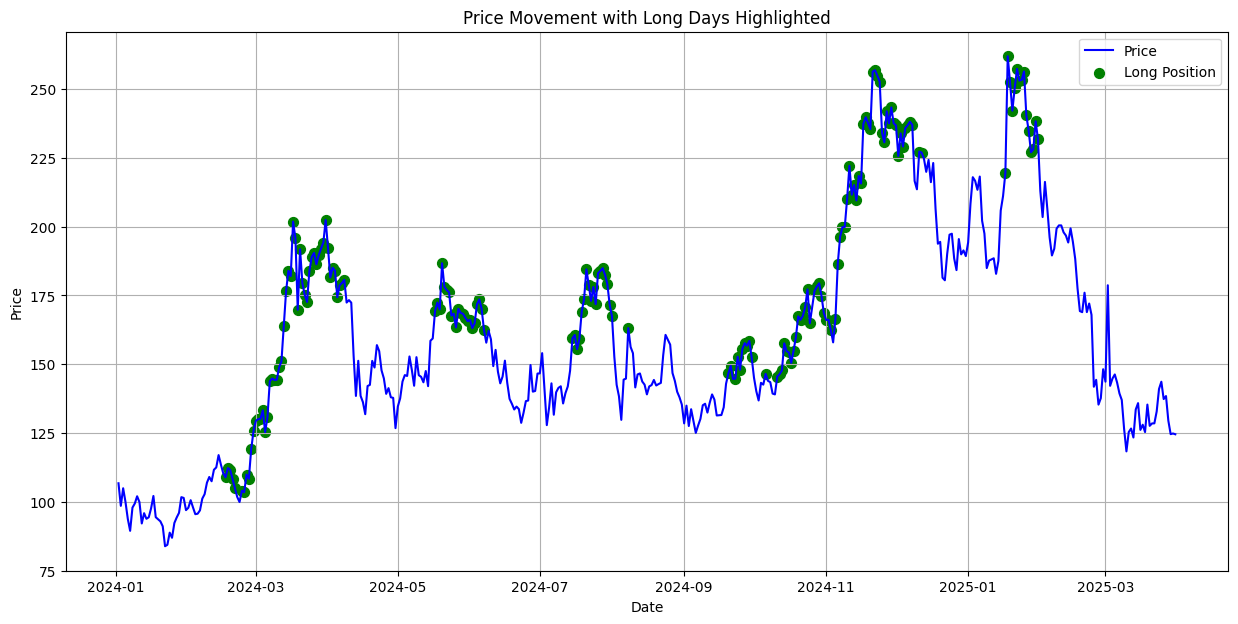

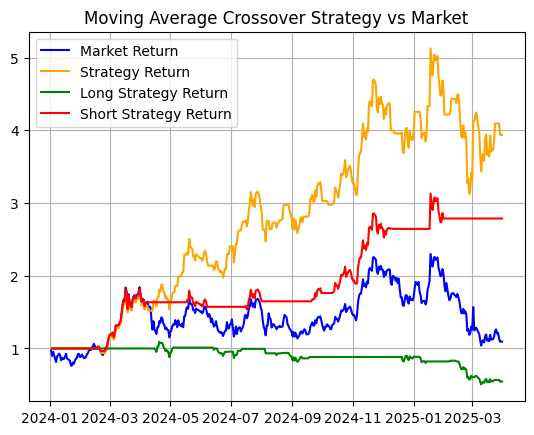

In [21]:
# Use optimal parameters from the best trial
optimal_params = study.best_trial.params
# optimal_params = {'window': 30, 'long': 1.4193168202203523, 'short': 1.0111870832321064, 'buy_long': 0.9804809925178282, 'buy_short': 0.9994090685190979}
objective(None, optimal_params=optimal_params)

# Plot setup
plt.figure(figsize=(15,7))

# Plot price
plt.plot(df.index, df['Close'], label='Price', color='blue')

# Highlight long days
long_days = df['Long'] == True
short_days = df['Short'] == True
plt.scatter(df.index[short_days], df['Close'][short_days], 
            label='Long Position', color='green', marker='o', s=50)

# Titles and labels
plt.title('Price Movement with Long Days Highlighted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

price = df['Close']

# # Calculate Moving Average
# window = 20  # e.g., 50 days
# sma = price.rolling(window=window).mean()

# # Trading signals
# df['Position'] = 0
# df['SMA'] = sma

# # Buy signal: price crosses above SMA
# df.loc[price > sma, 'Position'] = 1

# # Sell signal: price crosses below SMA
# df.loc[price <= sma, 'Position'] = 0

# # Shift position for returns
# df['Position'] = df['Position'].shift(1)

# # Returns
# df['Market Return'] = price.pct_change()
# df['Strategy Return'] = df['Position'] * df['Market Return']

# Plot cumulative returns
strat = (1 + df[['Market Return', 'Strategy Return']]).cumprod()
long_strat = (1 + df[['Market Return', 'Long Strategy Return']]).cumprod()
short_strat = (1 + df[['Market Return', 'Short Strategy Return']]).cumprod()

plt.plot(strat.index, strat['Market Return'], label='Market Return', color='blue')
plt.plot(strat.index, strat['Strategy Return'], label='Strategy Return', color='orange')
plt.plot(long_strat.index, long_strat['Long Strategy Return'], label='Long Strategy Return', color='green')
plt.plot(short_strat.index, short_strat['Short Strategy Return'], label='Short Strategy Return', color='red')
plt.title('Moving Average Crossover Strategy vs Market')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Extract trial parameters and results
trials_data = [
    {**trial.params, 'score': trial.value}
    for trial in study.trials
]

# Convert to a DataFrame
trials_df = pd.DataFrame(trials_data)

# Display the DataFrame
trials_df.sort_values(by="score", ascending=False)

,window,long,short,buy_long,buy_short,score
547,47,0.664440,0.393263,0.999912,0.948276,2.937405
542,47,0.665298,0.405474,0.999433,0.965109,2.905021
196,48,0.685170,0.369727,0.979147,0.959253,2.836127
612,48,0.682650,0.371773,0.978900,0.943913,2.815228
212,47,0.663856,0.373684,0.942010,0.961029,2.799149
...,...,...,...,...,...,...
8,16,0.302390,1.419921,0.897090,0.726432,-0.001734
929,9,0.669620,0.380660,0.982866,0.985079,-0.120492
757,7,1.776405,0.328028,0.946842,0.931919,-0.180956
571,9,0.756448,0.297713,0.963900,0.936713,-0.208020


In [12]:
trials_df.mean(), trials_df.std()

(window       45.395000
 long          0.758253
 short         0.438751
 buy_long      0.910568
 buy_short     0.899218
 score         1.639357
 dtype: float64,
 window       6.971627
 long         0.227013
 short        0.265049
 buy_long     0.162863
 buy_short    0.167277
 score        0.593452
 dtype: float64)

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler

X = np.array([list(t.params.values()) for t in study.trials if t.value is not None])
y = np.array([t.value for t in study.trials if t.value is not None])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) \
         + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e1))

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
gp.fit(X_scaled, y)

print("Learned kernel:", gp.kernel_)




Learned kernel: 1.15**2 * RBF(length_scale=0.904) + WhiteKernel(noise_level=0.192)


#### Interpretation from ChatGPT:
length-scale: 0.904, noise_level: 0.192
 - ~0.904 std-dev in the input space corresponds to significant change in predicted score.
 - about 19.2% of score variation is due to "noise"